# <center>Pipeline for Deep learning based Dose Prediction and Fluence Optimization </center>


This example showcases the core functionalities of the portpy.ai module, which is designed for deep learning-based dose prediction in the context of radiotherapy treatment planning. The main functionalities demonstrated are as follows:

1. **Data Access and Preprocessing**: The portpy.ai module allows easy access to curated portpy data, specifically tailored for training deep learning models for dose prediction. It also includes preprocessing steps to prepare the data for use in the models.

2. **Model Training and Testing**: With the portpy.ai module, users can efficiently train and test their deep learning models for dose prediction. This involves using the prepared data to create and fine-tune the models for optimal performance.

3. **Patient-Specific Dose Prediction**: The module enables the creation of personalized dose prediction for available patients in the PortPy database. This feature allows users to estimate the dose distribution for individual patients, aiding in treatment planning. Also, PortPy uses simple UNET model with MAE loss to create dose prediction. Users can implement their own customized models for better prediction and accuracy


4. **Fluence Optimization with Predicted Dose**: The predicted dose distribution can be used to optimize the fluence of radiation beams during treatment planning. The optimized fluence can be imported back to eclipse for final dose calculation. Please refer to [imrt_tps_import.ipynb](https://github.com/PortPy-Project/PortPy/blob/master/examples/imrt_tps_import.ipynb) for more details.

5. **Plan Visualization**: The module offers tools for visualizing treatment plans based on the predicted dose distribution. 

Overall, the portpy.ai module provides a comprehensive solution for dose prediction and treatment planning in radiotherapy, leveraging the power of deep learning and data-driven methodologies to enhance precision and patient-specific care.

**Note: At present, the PortPy dataset contains only 10 lung patients. However, using the PortPy AI module, treatment planning using dose prediction pipeline has been demonstrated successfully. By the end of August, an additional 100 lung patients will be added to the PortPy dataset, significantly enhancing the training data and thereby improving the performance of the dose prediction model. **

In [1]:
# append portpy directory to path
import sys
sys.path.append('..')

In [2]:
import portpy.photon as pp
import SimpleITK as sitk
import os
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from portpy.ai.preprocess.predict_using_model import predict_using_model
from portpy.ai.preprocess.data_preprocess import data_preprocess
from portpy.ai.train import train
from portpy.ai.test import test

In [3]:
# change directory to portpy ai module to preprocess the portpy data, train and test the model
# os.chdir('../portpy/ai')

**Note** When runnig it for the first time please install packages using requirements.txt 

In [4]:
# !pip install -r requirements.txt --user

### 1. Preprocess, train and test using PortPy AI module

In [3]:
in_dir = r'../data' # directory where portpy raw data is located
out_dir = r'../ai_data' # directory where processed data to be stored for training and testing model

In [1]:
# preprocess portpy data
data_preprocess(in_dir, out_dir)

**Note** split the data in train and test folder in the output directory before running further code
e.g. out_dir\train\Lung_Patient_2 out_dir\test\Lung_Patient_9

### 2. Training and testing the model

Train the model. You can change the parameters for the training as show below

In [6]:
# sys.argv[1:] = [] # Uncomment and run this in case if there is extra already in sys.argv of jupyter notebook

In [2]:
# Provide only the arguments you want to override
train_options = {
    "dataroot": "../ai_data",
    "checkpoints_dir": "../checkpoints",
    "netG": "unet_128",
    "name": "portpy_test_3",
    "model": "doseprediction3d",
    "direction": "AtoB",
    "lambda_L1": 1,
    "dataset_mode": "dosepred3d",
    "norm": "batch",
    "batch_size": 1,
    "pool_size": 0,
    "display_port": 8097,
    "lr": 0.0002,
    "input_nc": 8,
    "output_nc": 1,
    "display_freq": 10,
    "print_freq": 1,
    "gpu_ids": [0]  # Converted to a list since multiple GPUs may be supported
}

train(train_options)  # Run training directly in Jupyter Notebook

In [ ]:
# You can uncomment and run below in case if you want to run train script from CLI
#!python ../portpy/ai/train.py --dataroot ../ai_data --netG unet_128 --name portpy_test_3 --model doseprediction3d --direction AtoB --lambda_L1 1 --dataset_mode dosepred3d --norm batch --batch_size 1 --pool_size 0 --display_port 8097 --lr 0.0002 --input_nc 8 --output_nc 1 --display_freq 10 --print_freq 1 --gpu_ids 0

Test the model

In [3]:
test_options = {
    "dataroot": "../ai_data",
    "netG": "unet_128",
    "checkpoints_dir": "../checkpoints",
    "results_dir": "../results",
    "name": "portpy_test_3",
    "phase": "test",
    "mode": "eval",
    "eval": True,  # Boolean flag
    "model": "doseprediction3d",
    "input_nc": 8,
    "output_nc": 1,
    "direction": "AtoB",
    "dataset_mode": "dosepred3d",
    "norm": "batch"
}
test(test_options)

In [ ]:
# !python ../portpy/ai/test.py --dataroot ../ai_data --netG unet_128 --checkpoints_dir ../checkpoints --results_dir ../results --name portpy_test_2 --phase test --mode eval --eval --model doseprediction3d --input_nc 8 --output_nc 1 --direction Ato

### 3. Create dose prediction for the PortPy patient

After training the model, users can use their customized model to create dose prediction for any portpy patient. Below script would preprocess and predict for the patient

In [10]:
# For users who does not want to train and test, they can directly preprocess and predict using AI model
patient_id = 'Lung_Patient_4'
model_name = 'portpy_test_3'
pred_dose = predict_using_model(patient_id=patient_id, in_dir=in_dir, out_dir=out_dir, model_name=model_name, checkpoints_dir='../checkpoints', results_dir='../results')

Processing case Lung_Patient_4...
Creating BEV..
Loading sparse influence matrix...
Done


### 4. Fluence optimization using predicted dose

Predicted dose can then be used to create a optimal fluence. We demonstrate simple optimization can be done to create a fluence from predicted dose. The optimized fluence can be imported back to eclipse for final dose calculation. Please refer to [imrt_tps_import.ipynb](https://github.com/PortPy-Project/PortPy/blob/master/examples/imrt_tps_import.ipynb) for more details. 
Model formulation for the optimization is given below:

$
   \mbox{Minimize} \quad  ||A^{PTV}\mathbf{x}-pred^{ptv}||^2 + ||A^{oar}\mathbf{x}-pred^{oar}||^2_{+} + w_{sm}(smoothness \space objective)  
$

$
\quad \mathbf{x} \geq 0
$

Here, $\mathbf{A}$ represents the dose influence matrix, parameterizing the dose delivered to each voxel from each beamlet. $\mathbf{x}$ refers to the optimal beamlet intensities (also known as beam profiles or fluence map), while $pred$ stands for the predicted dose using the above dose prediction pipeline. The operators $||.||_{+}$  represent the positive of the input vector respectively. 

In [13]:
# load portpy data
data = pp.DataExplorer(data_dir=in_dir)
data.patient_id = patient_id
# Load ct and structure set for the above patient using CT and Structures class
ct = pp.CT(data)
structs = pp.Structures(data)

beams = pp.Beams(data)

# load clinical criteria from the config files for which plan to be optimized
protocol_name = 'Lung_2Gy_30Fx'
clinical_criteria = pp.ClinicalCriteria(data, protocol_name=protocol_name)

# create rinds based upon rind definition in optimization params
protocol_name = 'Lung_2Gy_30Fx'
opt_params = data.load_config_opt_params(protocol_name=protocol_name)
# structs.create_opt_structures(opt_params)

# load influence matrix based upon beams and structure set
inf_matrix = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)

pred_dose_1d = inf_matrix.dose_3d_to_1d(dose_3d=pred_dose)

# create a plan using ct, structures, beams and influence matrix. Clinical criteria is optional
my_plan = pp.Plan(ct=ct, structs=structs, beams=beams, inf_matrix=inf_matrix, clinical_criteria=clinical_criteria)

Creating BEV..
Loading sparse influence matrix...
Done


In [14]:
# create cvxpy problem using the clinical criteria and optimization parameters
opt = pp.Optimization(my_plan, opt_params=opt_params)
# x = opt.vars['x']
A = inf_matrix.A
x = cp.Variable(A.shape[1], pos=True)
opt.vars['x'] = x
ptv_vox = inf_matrix.get_opt_voxels_idx('PTV')
opt.obj += [
    (1 / len(ptv_vox)) * cp.sum_squares(A[ptv_vox, :] @ x - pred_dose_1d[ptv_vox] / my_plan.get_num_of_fractions())]
# voxel weights for oar objectives
all_vox = np.arange(A.shape[0])
oar_voxels = all_vox[~np.isin(np.arange(A.shape[0]), ptv_vox)]
dO = cp.Variable(oar_voxels.shape[0], pos=True)
opt.constraints += [A[oar_voxels, :] @ x <= pred_dose_1d[oar_voxels] / my_plan.get_num_of_fractions() + dO]
opt.obj += [(1 / dO.shape[0]) * cp.sum_squares(dO)]

[Qx, Qy, num_rows, num_cols] = opt.get_smoothness_matrix(inf_matrix.beamlets_dict)
smoothness_X_weight = 0.6
smoothness_Y_weight = 0.4
opt.obj += [(smoothness_X_weight * (1 / num_cols) * cp.sum_squares(Qx @ x) +
            smoothness_Y_weight * (1 / num_rows) * cp.sum_squares(Qy @ x))]

sol = opt.solve(solver='MOSEK', verbose=False)
sol = {'optimal_intensity': x.value, 'inf_matrix': inf_matrix}

Running Optimization..
Optimal value: 0.005545637489107733
Elapsed time: 37.75325131416321 seconds


### 5. Plan visualization

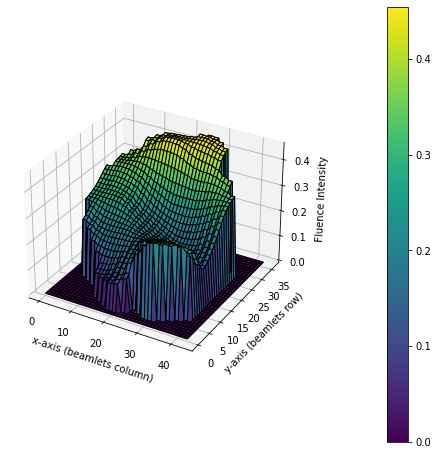

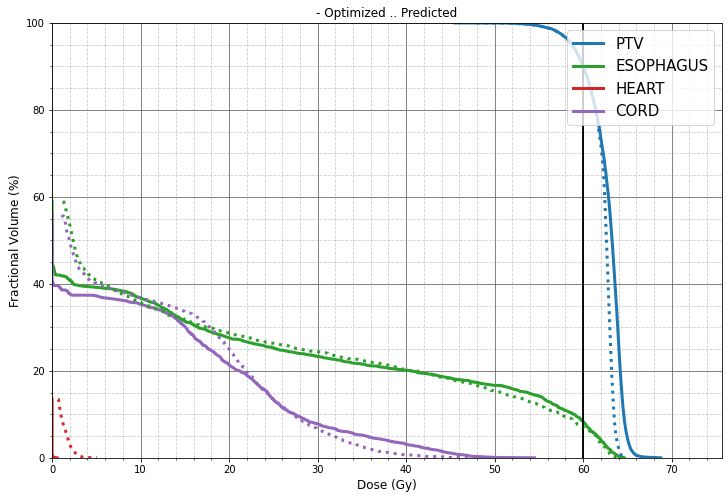

In [15]:
# plot fluence 3d and 2d for the 1st beam
pp.Visualization.plot_fluence_3d(sol=sol, beam_id=my_plan.beams.get_all_beam_ids()[0])

struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
fig, ax = plt.subplots(figsize=(12, 8))
ax = pp.Visualization.plot_dvh(my_plan, sol=sol, struct_names=struct_names, style='solid', ax=ax, norm_flag=True)
ax = pp.Visualization.plot_dvh(my_plan, dose_1d=pred_dose_1d, struct_names=struct_names, style='dotted', ax=ax,
                               norm_flag=True)
ax.set_title('- Optimized .. Predicted')
plt.show()